In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
openai_data = pd.read_parquet("/Users/antoniozhong/Documents/dev/purdue/MSR2026/github_perf_patch_study/RQ3/rq3_validation_evidence_openai.parquet")
gemini_data = pd.read_parquet("/Users/antoniozhong/Documents/dev/purdue/MSR2026/github_perf_patch_study/RQ3/rq3_validation_evidence_gemini.parquet")

In [6]:
len(openai_data), len(gemini_data)

(407, 407)

/var/folders/9l/dq9r8b6n1bx49mhvn82gzl180000gn/T/ipykernel_7701/3843816953.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["validation_present"] = df["validation_present"].fillna(df["validation_type"].ne("none"))


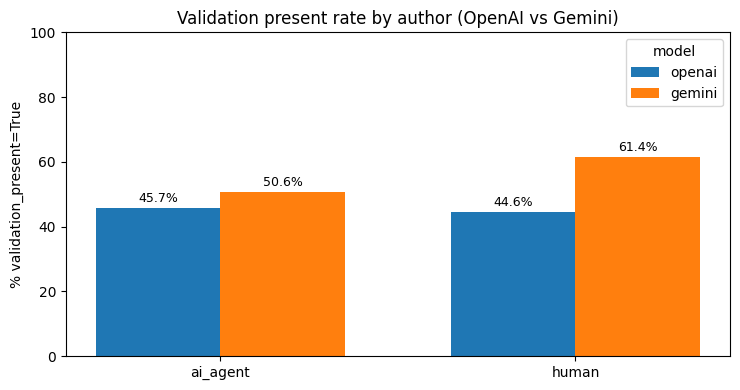

In [10]:
# ============================================================
# 1) ONE FIGURE: Validation present rate (OpenAI vs Gemini)
#    Grouped bars by author_type
#    Assumes you already have:
#      openai_data, gemini_data
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

AUTHOR_ORDER = ["ai_agent", "human"]

def _norm_present(df, model_name):
    df = df.copy()
    df["model"] = model_name
    if "author_type" not in df.columns:
        df["author_type"] = "unknown"
    if "validation_type" not in df.columns:
        df["validation_type"] = "none"
    if "validation_present" not in df.columns:
        df["validation_present"] = np.nan

    df["author_type"] = df["author_type"].fillna("unknown").astype(str)
    df["validation_type"] = df["validation_type"].fillna("none").astype(str)
    df["validation_present"] = df["validation_present"].fillna(df["validation_type"].ne("none"))
    df["validation_present"] = df["validation_present"].astype(bool)
    return df

openai_df = _norm_present(openai_data, "openai")
gemini_df = _norm_present(gemini_data, "gemini")
all_df = pd.concat([openai_df, gemini_df], ignore_index=True)
all_df = all_df[all_df["author_type"].isin(AUTHOR_ORDER)].copy()

present_rate = (
    all_df.groupby(["model", "author_type"])["validation_present"]
    .mean()
    .mul(100)
    .unstack()
    .reindex(index=["openai", "gemini"])
    .reindex(columns=AUTHOR_ORDER)
)

# ---- Plot grouped bars (one figure) ----
x = np.arange(len(AUTHOR_ORDER))
width = 0.35

fig, ax = plt.subplots(figsize=(7.5, 4))
ax.bar(x - width/2, present_rate.loc["openai"].values, width, label="openai")
ax.bar(x + width/2, present_rate.loc["gemini"].values, width, label="gemini")

ax.set_title("Validation present rate by author (OpenAI vs Gemini)")
ax.set_ylabel("% validation_present=True")
ax.set_xticks(x)
ax.set_xticklabels(AUTHOR_ORDER)
ax.set_ylim(0, 100)
ax.legend(title="model")

# labels
for i, v in enumerate(present_rate.loc["openai"].values):
    ax.text(i - width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
for i, v in enumerate(present_rate.loc["gemini"].values):
    ax.text(i + width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

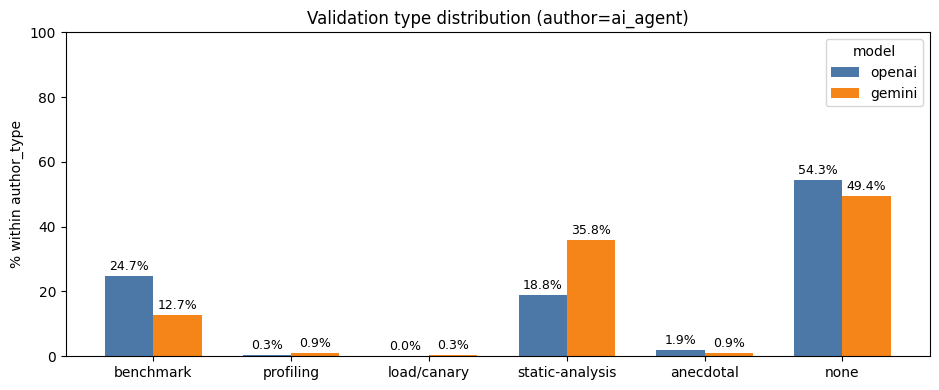

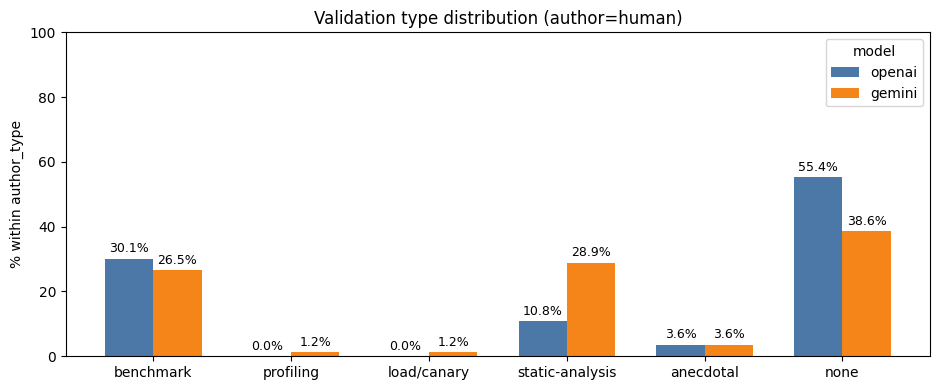

In [15]:
# ============================================================
# 2) SPLIT FIGURE: Validation type distribution
#    Two separate charts:
#      - author = ai_agent
#      - author = human
#    Grouped bars: OpenAI vs Gemini across validation types
#    SAME COLORS as your evidence-source chart
#
# Assumes you already have:
#   openai_data, gemini_data
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

VALIDATION_ORDER = [
    "benchmark",
    "profiling",
    "load/canary",
    "static-analysis",
    "anecdotal",
    "none",
]
AUTHOR_ORDER = ["ai_agent", "human"]

OPENAI_COLOR = "#4c78a8"
GEMINI_COLOR = "#f58518"

def _norm_types(df, model_name):
    df = df.copy()
    df["model"] = model_name
    if "author_type" not in df.columns:
        df["author_type"] = "unknown"
    if "validation_type" not in df.columns:
        df["validation_type"] = "none"

    df["author_type"] = df["author_type"].fillna("unknown").astype(str)
    df["validation_type"] = df["validation_type"].fillna("none").astype(str)
    return df

openai_df = _norm_types(openai_data, "openai")
gemini_df = _norm_types(gemini_data, "gemini")
all_df = pd.concat([openai_df, gemini_df], ignore_index=True)
all_df = all_df[all_df["author_type"].isin(AUTHOR_ORDER)].copy()

# counts -> pct within (model, author)
counts = (
    all_df.groupby(["model", "author_type", "validation_type"])
    .size()
    .unstack(fill_value=0)
)

for t in VALIDATION_ORDER:
    if t not in counts.columns:
        counts[t] = 0
counts = counts[VALIDATION_ORDER]

pct = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0).mul(100)

def plot_validation_type_for_author(author: str):
    openai_vals = (
        pct.loc[("openai", author)].reindex(VALIDATION_ORDER).values
        if ("openai", author) in pct.index else np.zeros(len(VALIDATION_ORDER))
    )
    gemini_vals = (
        pct.loc[("gemini", author)].reindex(VALIDATION_ORDER).values
        if ("gemini", author) in pct.index else np.zeros(len(VALIDATION_ORDER))
    )

    x = np.arange(len(VALIDATION_ORDER))
    width = 0.35

    fig, ax = plt.subplots(figsize=(9.5, 4))

    ax.bar(x - width/2, openai_vals, width, label="openai", color=OPENAI_COLOR)
    ax.bar(x + width/2, gemini_vals, width, label="gemini", color=GEMINI_COLOR)

    ax.set_title(f"Validation type distribution (author={author})")
    ax.set_ylabel("% within author_type")
    ax.set_xlabel("")
    ax.set_xticks(x)
    ax.set_xticklabels(VALIDATION_ORDER)
    ax.set_ylim(0, 100)
    ax.legend(title="model")

    # Percentage labels
    for i, v in enumerate(openai_vals):
        ax.text(i - width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(gemini_vals):
        ax.text(i + width/2, v + 1, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

# Two separate figures
plot_validation_type_for_author("ai_agent")
plot_validation_type_for_author("human")

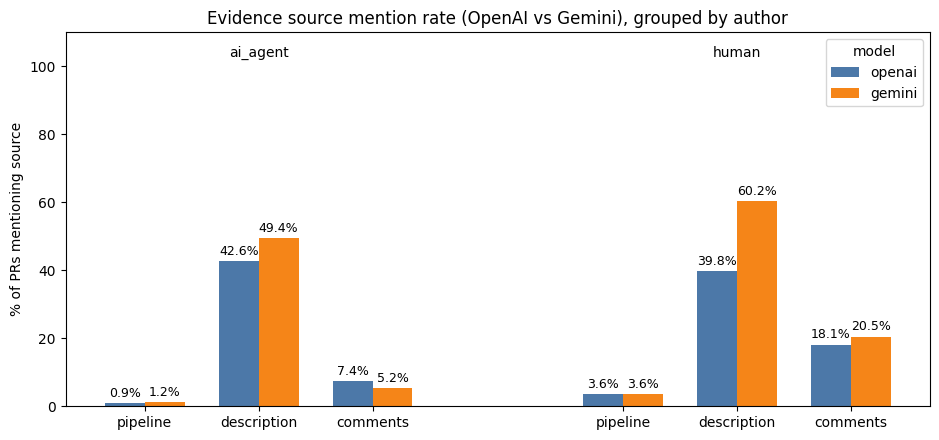

In [19]:
# ============================================================
# 3) ONE FIGURE: Evidence source (OpenAI vs Gemini)
#    Grouped bars by author_type
#    Metric: % of PRs that mention each source
#    SAME COLORS per model (consistent)
#    Assumes you already have:
#      openai_data, gemini_data
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

AUTHOR_ORDER = ["ai_agent", "human"]
SOURCE_ORDER = ["pipeline", "description", "comments"]

# ✅ Set consistent colors per model
OPENAI_COLOR = "#4c78a8"
GEMINI_COLOR = "#f58518"

def _norm_sources(df, model_name):
    df = df.copy()
    df["model"] = model_name

    if "author_type" not in df.columns:
        df["author_type"] = "unknown"
    if "evidence_sources" not in df.columns:
        df["evidence_sources"] = np.nan

    df["author_type"] = df["author_type"].fillna("unknown").astype(str)

    def to_list(x):
        if isinstance(x, list):
            return x
        if isinstance(x, tuple):
            return list(x)
        if isinstance(x, np.ndarray):
            return x.tolist()
        # only call pd.isna on scalar-like values to avoid ambiguous truth for arrays
        if not isinstance(x, (list, tuple, np.ndarray)) and pd.isna(x):
            return []
        if isinstance(x, str):
            s = x.strip()
            if s.startswith("[") and s.endswith("]"):
                inner = s[1:-1].strip()
                if not inner:
                    return []
                return [p.strip().strip("'").strip('"') for p in inner.split(",")]
            return [s]
        return []

    df["evidence_sources"] = df["evidence_sources"].apply(to_list)
    return df

openai_df = _norm_sources(openai_data, "openai")
gemini_df = _norm_sources(gemini_data, "gemini")
all_df = pd.concat([openai_df, gemini_df], ignore_index=True)
all_df = all_df[all_df["author_type"].isin(AUTHOR_ORDER)].copy()

# Create boolean flags per source
flags = pd.DataFrame({
    "pipeline": all_df["evidence_sources"].apply(lambda xs: "pipeline" in xs),
    "description": all_df["evidence_sources"].apply(lambda xs: "description" in xs),
    "comments": all_df["evidence_sources"].apply(lambda xs: "comments" in xs),
})
flags = pd.concat([all_df[["model", "author_type"]].reset_index(drop=True), flags], axis=1)

# % of PRs mentioning each source, within (model, author)
ev_rate = (
    flags.groupby(["model", "author_type"])[SOURCE_ORDER]
    .mean()
    .mul(100)
)

# Plot setup:
# x-axis categories = sources, repeated per author block
fig, ax = plt.subplots(figsize=(9.5, 4.5))

n_sources = len(SOURCE_ORDER)
gap = 1.2
block_width = n_sources + gap
width = 0.35

for a_idx, author in enumerate(AUTHOR_ORDER):
    base = a_idx * block_width
    xs = np.arange(n_sources) + base

    openai_vals = (
        ev_rate.loc[("openai", author)].reindex(SOURCE_ORDER).values
        if ("openai", author) in ev_rate.index else np.zeros(n_sources)
    )
    gemini_vals = (
        ev_rate.loc[("gemini", author)].reindex(SOURCE_ORDER).values
        if ("gemini", author) in ev_rate.index else np.zeros(n_sources)
    )

    ax.bar(
        xs - width/2, openai_vals, width,
        label="openai" if a_idx == 0 else None,
        color=OPENAI_COLOR
    )
    ax.bar(
        xs + width/2, gemini_vals, width,
        label="gemini" if a_idx == 0 else None,
        color=GEMINI_COLOR
    )

    ax.text(xs.mean(), 102, author, ha="center", va="bottom", fontsize=10)

# ticks
xticks = []
xlabels = []
for a_idx, author in enumerate(AUTHOR_ORDER):
    base = a_idx * block_width
    xs = np.arange(n_sources) + base
    xticks.extend(xs.tolist())
    xlabels.extend(SOURCE_ORDER)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.set_ylabel("% of PRs mentioning source")
ax.set_title("Evidence source mention rate (OpenAI vs Gemini), grouped by author")
ax.set_ylim(0, 110)
ax.legend(title="model")

# labels
for p in ax.patches:
    h = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2, h + 1,
        f"{h:.1f}%", ha="center", va="bottom", fontsize=9
    )

plt.tight_layout()
plt.show()